In [3]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=d2fafc05d8eb61d89c421226dafcb6709ff44e765635f354d9f6445a3ed6ba1a
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:

import tarfile
from torchvision.datasets.utils import download_url
import torchvision.transforms as tt
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import f1_score,confusion_matrix
import os
import torch
from PIL import Image
import wandb
import torch.nn as nn
import scipy.io
import numpy as np

In [5]:
#wandb initilization
wandb.login()
wandb.init(project="CV_A1_Q3_1", entity="iiitd")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: manvendra (iiitd). Use `wandb login --relogin` to force relogin


In [6]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [7]:
import zipfile
with zipfile.ZipFile(r'/gdrive/MyDrive/A1/svhn_yolo.zip', 'a') as zip_ref:
    zip_ref.extractall(path = r'/content/datai')

In [8]:

class DataSet(torch.utils.data.Dataset):
    def __init__(self, root='/content/datai/svhn', transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images/all/"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "labels/all/"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images/all/", self.imgs[idx])
        mask_path = os.path.join(self.root, "labels/all/", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        meta = []
        if self.transforms is not None:
          img = self.transforms(img)


        with open(mask_path) as f:
          for i in f.readlines():
            liz = list(map(float,i.split()))
            liz[0] = int(liz[0])
            meta.append(liz)

        return img, meta
        # obj_ids = np.unique(mask)
        # # first id is the background, so remove it
        # obj_ids = obj_ids[1:]

        # # split the color-encoded mask into a set
        # # of binary masks
        # masks = mask == obj_ids[:, None, None]

        # # get bounding box coordinates for each mask
        # num_objs = len(obj_ids)
        # boxes = []
        # for i in range(num_objs):
        #     pos = np.where(masks[i])
        #     xmin = np.min(pos[1])
        #     xmax = np.max(pos[1])
        #     ymin = np.min(pos[0])
        #     ymax = np.max(pos[0])
        #     boxes.append([xmin, ymin, xmax, ymax])
    def __len__(self):
      return len(self.imgs)

In [9]:
trans = tt.Compose([
    tt.ToTensor(),tt.Resize((28,28))
])

data= DataSet('/content/datai/svhn',trans)


In [10]:
test_size = int(len(data)*0.1)
val_size = int(len(data)*0.2)
train_size = len(data)-test_size-val_size

train_ds, val_ds ,test_ds = random_split(data, [train_size,val_size, test_size])

print(len(train_ds), len(val_ds),len(test_ds))

23382 6680 3340


In [11]:
train_ds[0][1]

[[2,
  0.47520661157024796,
  0.4444444444444444,
  0.09090909090909091,
  0.5714285714285714],
 [3,
  0.5413223140495868,
  0.4126984126984127,
  0.10743801652892562,
  0.5714285714285714]]

In [12]:
from collections import Counter
train_class={i:0 for i in range(0,10)}
for i in train_ds:  
  for j in i[1]:
    train_class[j[0]] +=1
  
  

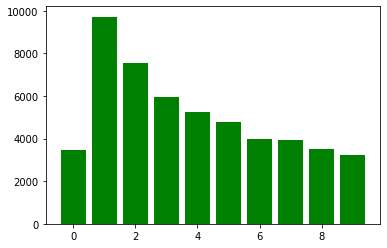

In [13]:
plt.bar(list(train_class.keys()), train_class.values(), color='g')
plt.show()

In [14]:
from collections import Counter
test_class={i:0 for i in range(0,10)}
for i in test_ds:  
  for j in i[1]:
    test_class[j[0]] +=1
  
  

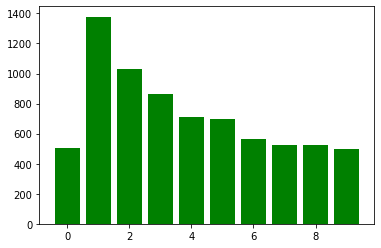

In [15]:
plt.bar(list(test_class.keys()), test_class.values(), color='g')
plt.show()

In [16]:
os.mkdir('/content/train_data')

In [17]:
os.mkdir('/content/train_data/images/')
os.mkdir('/content/train_data/labels/')

In [18]:
os.mkdir('/content/train_data/images/train')
os.mkdir('/content/train_data/images/val')
os.mkdir('/content/train_data/images/test')

In [19]:
os.mkdir('/content/train_data/labels/train')
os.mkdir('/content/train_data/labels/val')
os.mkdir('/content/train_data/labels/test')

In [20]:

class DataSet():
    def __init__(self, root='/content/datai/svhn'):
        self.root = root
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images/all/"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "labels/all/"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images/all/", self.imgs[idx])
        mask_path = os.path.join(self.root, "labels/all/", self.masks[idx])
        return img_path,mask_path

    def __len__(self):
      return len(self.imgs)

In [21]:
train_ds_cr= DataSet('/content/datai/svhn')
test_size = int(len(train_ds_cr)*0.1)
val_size = int(len(train_ds_cr)*0.2)
train_size = len(train_ds_cr)-test_size-val_size

train_ds, val_ds ,test_ds = random_split(train_ds_cr, [train_size,val_size, test_size])

print(len(train_ds), len(val_ds),len(test_ds))

23382 6680 3340


In [22]:
import shutil


for i,j in train_ds:
  print(i,j)
  shutil.copy(i, '/content/train_data/images/train/')
  shutil.copy(j, '/content/train_data/labels/train/')
  

Streaming output truncated to the last 5000 lines.
/content/datai/svhn/images/all/16343.png /content/datai/svhn/labels/all/16343.txt
/content/datai/svhn/images/all/18571.png /content/datai/svhn/labels/all/18571.txt
/content/datai/svhn/images/all/30760.png /content/datai/svhn/labels/all/30760.txt
/content/datai/svhn/images/all/15351.png /content/datai/svhn/labels/all/15351.txt
/content/datai/svhn/images/all/21363.png /content/datai/svhn/labels/all/21363.txt
/content/datai/svhn/images/all/472.png /content/datai/svhn/labels/all/472.txt
/content/datai/svhn/images/all/18279.png /content/datai/svhn/labels/all/18279.txt
/content/datai/svhn/images/all/26363.png /content/datai/svhn/labels/all/26363.txt
/content/datai/svhn/images/all/26189.png /content/datai/svhn/labels/all/26189.txt
/content/datai/svhn/images/all/32542.png /content/datai/svhn/labels/all/32542.txt
/content/datai/svhn/images/all/29884.png /content/datai/svhn/labels/all/29884.txt
/content/datai/svhn/images/all/19784.png /content/d

In [23]:

for i,j in val_ds:
  print(i,j)
  shutil.copy(i, '/content/train_data/images/val/')
  shutil.copy(j, '/content/train_data/labels/val/')
  

Streaming output truncated to the last 5000 lines.
/content/datai/svhn/images/all/17416.png /content/datai/svhn/labels/all/17416.txt
/content/datai/svhn/images/all/15568.png /content/datai/svhn/labels/all/15568.txt
/content/datai/svhn/images/all/5182.png /content/datai/svhn/labels/all/5182.txt
/content/datai/svhn/images/all/31307.png /content/datai/svhn/labels/all/31307.txt
/content/datai/svhn/images/all/30278.png /content/datai/svhn/labels/all/30278.txt
/content/datai/svhn/images/all/23020.png /content/datai/svhn/labels/all/23020.txt
/content/datai/svhn/images/all/811.png /content/datai/svhn/labels/all/811.txt
/content/datai/svhn/images/all/1735.png /content/datai/svhn/labels/all/1735.txt
/content/datai/svhn/images/all/4525.png /content/datai/svhn/labels/all/4525.txt
/content/datai/svhn/images/all/13533.png /content/datai/svhn/labels/all/13533.txt
/content/datai/svhn/images/all/12714.png /content/datai/svhn/labels/all/12714.txt
/content/datai/svhn/images/all/32148.png /content/datai/s

In [24]:
import shutil


for i,j in test_ds:
  print(i,j)
  shutil.copy(i, '/content/train_data/images/test/')
  shutil.copy(j, '/content/train_data/labels/test/')

/content/datai/svhn/images/all/30375.png /content/datai/svhn/labels/all/30375.txt
/content/datai/svhn/images/all/14502.png /content/datai/svhn/labels/all/14502.txt
/content/datai/svhn/images/all/6841.png /content/datai/svhn/labels/all/6841.txt
/content/datai/svhn/images/all/28575.png /content/datai/svhn/labels/all/28575.txt
/content/datai/svhn/images/all/21569.png /content/datai/svhn/labels/all/21569.txt
/content/datai/svhn/images/all/5079.png /content/datai/svhn/labels/all/5079.txt
/content/datai/svhn/images/all/9924.png /content/datai/svhn/labels/all/9924.txt
/content/datai/svhn/images/all/12214.png /content/datai/svhn/labels/all/12214.txt
/content/datai/svhn/images/all/3337.png /content/datai/svhn/labels/all/3337.txt
/content/datai/svhn/images/all/10453.png /content/datai/svhn/labels/all/10453.txt
/content/datai/svhn/images/all/10411.png /content/datai/svhn/labels/all/10411.txt
/content/datai/svhn/images/all/10436.png /content/datai/svhn/labels/all/10436.txt
/content/datai/svhn/imag

In [1]:
!git clone https://github.com/ultralytics/yolov5 

Cloning into 'yolov5'...
remote: Enumerating objects: 15236, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15236 (delta 6), reused 12 (delta 4), pack-reused 15218
Receiving objects: 100% (15236/15236), 14.17 MiB | 17.76 MiB/s, done.
Resolving deltas: 100% (10449/10449), done.


In [2]:
#!git clone https://github.com/ultralytics/yolov5  # clone
import os
%cd yolov5
%pip install -qr requirements.txt  # install
os.chdir('/content/yolov5')

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.4/78.2 GB disk)


In [25]:
os.chdir('/content/yolov5')

In [26]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images

detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

100% 14.1M/14.1M [00:00<00:00, 20.8MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 19.7ms
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, 15.4ms
Speed: 0.5ms pre-process, 17.5ms inference, 23.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


In [28]:
!python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: manvendra (iiitd). Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hype

In [42]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data coco128.yaml --img 640

val: data=/content/yolov5/data/coco128.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/train_data/labels/val.cache... 6680 images, 0 backgrounds, 0 corrupt: 100% 6680/6680 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 209/209 [01:05<00:00,  3.21it/s]
                   all       6680      14645      0.891      0.832      0.902      0.452
                     0       6680       1001      0.873      0.911      0.929      0.493

In [43]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data coco128-seg.yaml --img 640

val: data=/content/yolov5/data/coco128-seg.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/train_data/labels/test... 3340 images, 0 backgrounds, 0 corrupt: 100% 3340/3340 [00:02<00:00, 1405.10it/s]
val: New cache created: /content/train_data/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 105/105 [00:33<00:00,  3.16it/s]
                   all       3340       7328      0.885      0.829      0.895      0.447
                 

In [44]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data coco128-seg.yaml --img 640 --iou 0.1

val: data=/content/yolov5/data/coco128-seg.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.1, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/train_data/labels/test.cache... 3340 images, 0 backgrounds, 0 corrupt: 100% 3340/3340 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 105/105 [00:30<00:00,  3.39it/s]
                   all       3340       7328      0.884      0.831      0.893      0.445
                     0       3340        495      0.856       0.91      0.928      

In [45]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data coco128-seg.yaml --img 640 --iou 0.2

val: data=/content/yolov5/data/coco128-seg.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.2, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/train_data/labels/test.cache... 3340 images, 0 backgrounds, 0 corrupt: 100% 3340/3340 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 105/105 [00:31<00:00,  3.37it/s]
                   all       3340       7328      0.885      0.831      0.895      0.446
                     0       3340        495      0.858      0.909      0.929      

In [46]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data coco128-seg.yaml --img 640 --iou 0.3

val: data=/content/yolov5/data/coco128-seg.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.3, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/train_data/labels/test.cache... 3340 images, 0 backgrounds, 0 corrupt: 100% 3340/3340 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 105/105 [00:31<00:00,  3.37it/s]
                   all       3340       7328      0.884      0.831      0.895      0.445
                     0       3340        495      0.856      0.909      0.929      

In [47]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data coco128-seg.yaml --img 640 --iou 0.4

val: data=/content/yolov5/data/coco128-seg.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.4, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/train_data/labels/test.cache... 3340 images, 0 backgrounds, 0 corrupt: 100% 3340/3340 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 105/105 [00:31<00:00,  3.33it/s]
                   all       3340       7328      0.885      0.831      0.895      0.445
                     0       3340        495      0.858      0.909      0.927      

In [48]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data coco128-seg.yaml --img 640 --iou 0.5

val: data=/content/yolov5/data/coco128-seg.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.5, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/train_data/labels/test.cache... 3340 images, 0 backgrounds, 0 corrupt: 100% 3340/3340 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 105/105 [00:31<00:00,  3.33it/s]
                   all       3340       7328      0.885       0.83      0.895      0.445
                     0       3340        495      0.859      0.907      0.928      

In [49]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data coco128-seg.yaml --img 640 --iou 0.6

val: data=/content/yolov5/data/coco128-seg.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/train_data/labels/test.cache... 3340 images, 0 backgrounds, 0 corrupt: 100% 3340/3340 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 105/105 [00:31<00:00,  3.33it/s]
                   all       3340       7328      0.885      0.829      0.895      0.447
                     0       3340        495      0.861      0.907      0.929      

In [50]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data coco128-seg.yaml --img 640 --iou 0.7

val: data=/content/yolov5/data/coco128-seg.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/train_data/labels/test.cache... 3340 images, 0 backgrounds, 0 corrupt: 100% 3340/3340 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 105/105 [00:32<00:00,  3.24it/s]
                   all       3340       7328      0.888      0.824      0.889      0.451
                     0       3340        495      0.863      0.905      0.926      

In [51]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data coco128-seg.yaml --img 640 --iou 0.8

val: data=/content/yolov5/data/coco128-seg.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.8, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/train_data/labels/test.cache... 3340 images, 0 backgrounds, 0 corrupt: 100% 3340/3340 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 105/105 [00:32<00:00,  3.18it/s]
                   all       3340       7328      0.869      0.796      0.856      0.446
                     0       3340        495      0.874      0.881      0.913      

In [52]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data coco128-seg.yaml --img 640 --iou 0.9

val: data=/content/yolov5/data/coco128-seg.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.9, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-108-g4db6757 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/train_data/labels/test.cache... 3340 images, 0 backgrounds, 0 corrupt: 100% 3340/3340 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 105/105 [00:36<00:00,  2.85it/s]
                   all       3340       7328      0.675      0.681       0.69      0.372
                     0       3340        495      0.649      0.783       0.76      

In [53]:
archived = shutil.make_archive('/content/myyolovQ3_1', 'zip', '/content/yolov5')